Caso de estudio 1 - Laberinto simple


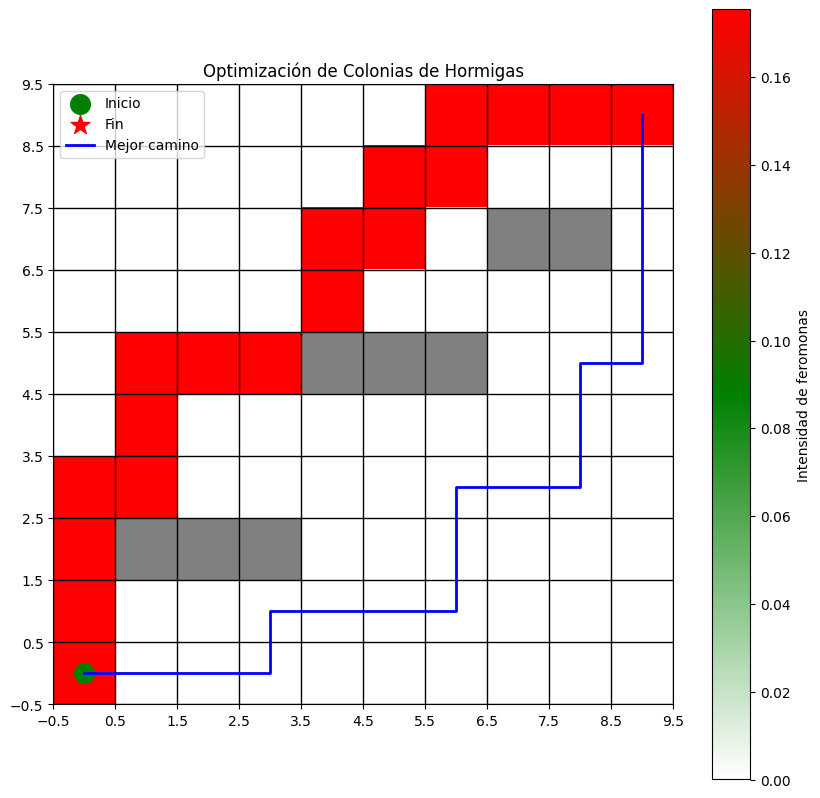

Mejor camino encontrado: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (4, 1), (5, 1), (6, 1), (6, 2), (6, 3), (7, 3), (8, 3), (8, 4), (8, 5), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
Longitud del camino: 19

Caso de estudio 2 - Laberinto más complejo


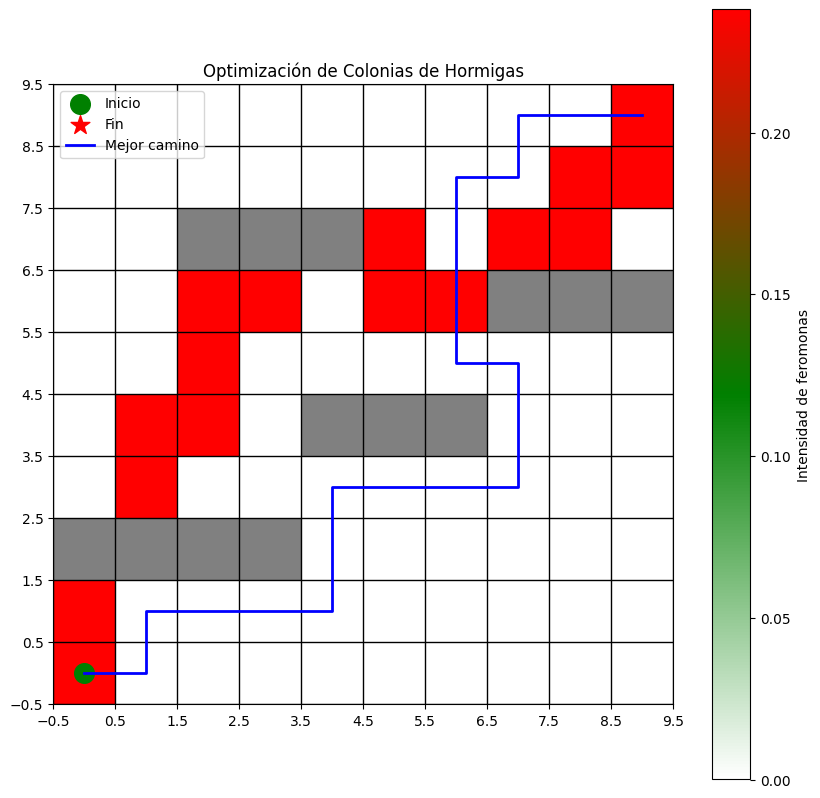

Mejor camino encontrado: [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (5, 3), (6, 3), (7, 3), (7, 4), (7, 5), (6, 5), (6, 6), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (9, 9)]
Longitud del camino: 21


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class AntColonyOptimization:
    def __init__(self, start, end, obstacles, grid_size=(10, 10), num_ants=20, evaporation_rate=0.5, alpha=1, beta=5):
        self.start = start
        self.end = end
        self.obstacles = obstacles
        self.grid_size = grid_size
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha  # Peso de las feromonas
        self.beta = beta    # Peso de la heurística
        self.pheromones = np.ones(grid_size)
        self.best_path = None
        self.best_path_length = float('inf')

    def _get_neighbors(self, position):
        pos_x, pos_y = position
        neighbors = []
        # Movimientos en 4 direcciones (no diagonal)
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            new_x, new_y = pos_x + dx, pos_y + dy
            if (0 <= new_x < self.grid_size[0] and 0 <= new_y < self.grid_size[1] and
                    (new_x, new_y) not in self.obstacles):
                neighbors.append((new_x, new_y))
        return neighbors

    def _select_next_position(self, position, visited):
        neighbors = self._get_neighbors(position)
        valid_neighbors = [n for n in neighbors if n not in visited]
        
        if not valid_neighbors:
            return None
            
        probabilities = []
        total = 0
        
        for neighbor in valid_neighbors:
            pheromone = self.pheromones[neighbor[1], neighbor[0]]
            distance = np.linalg.norm(np.array(neighbor) - np.array(self.end))
            heuristic = 1 / (distance + 0.1)  # Evitar división por cero
            prob = (pheromone ** self.alpha) * (heuristic ** self.beta)
            probabilities.append((neighbor, prob))
            total += prob
        
        if total == 0:
            return np.random.choice(valid_neighbors)
            
        probabilities = [(pos, prob / total) for pos, prob in probabilities]
        selected = np.random.choice(len(probabilities), p=[prob for pos, prob in probabilities])
        return probabilities[selected][0]

    def _evaporate_pheromones(self):
        self.pheromones *= (1 - self.evaporation_rate)

    def _deposit_pheromones(self, path):
        path_length = len(path)
        if path_length > 0:
            deposit_amount = 1.0 / path_length
            for position in path:
                self.pheromones[position[1], position[0]] += deposit_amount

    def find_best_path(self, num_iterations):
        for _ in range(num_iterations):
            all_paths = []
            for _ in range(self.num_ants):
                current_position = self.start
                path = [current_position]
                visited = set(path)
                
                while current_position != self.end:
                    next_position = self._select_next_position(current_position, visited)
                    if next_position is None:
                        break
                    path.append(next_position)
                    visited.add(next_position)
                    current_position = next_position
                
                # Solo considerar caminos que llegan al destino
                if path[-1] == self.end:
                    all_paths.append(path)

            # Actualizar el mejor camino encontrado
            if all_paths:
                current_best_path = min(all_paths, key=lambda x: len(x))
                current_best_length = len(current_best_path)
                
                if current_best_length < self.best_path_length:
                    self.best_path = current_best_path
                    self.best_path_length = current_best_length

            # Actualizar feromonas
            self._evaporate_pheromones()
            if all_paths:
                self._deposit_pheromones(current_best_path)

    def plot(self):
        cmap = LinearSegmentedColormap.from_list('pheromone', ['white', 'green', 'red'])
        plt.figure(figsize=(10, 10))
        plt.imshow(self.pheromones.T, cmap=cmap, origin='lower')
        plt.colorbar(label='Intensidad de feromonas')
        
        # Dibujar obstáculos
        for obstacle in self.obstacles:
            plt.fill([obstacle[0]-0.5, obstacle[0]+0.5, obstacle[0]+0.5, obstacle[0]-0.5],
                    [obstacle[1]-0.5, obstacle[1]-0.5, obstacle[1]+0.5, obstacle[1]+0.5],
                    'gray')
        
        # Dibujar inicio y fin
        plt.scatter(self.start[0], self.start[1], color='green', s=200, marker='o', label='Inicio')
        plt.scatter(self.end[0], self.end[1], color='red', s=200, marker='*', label='Fin')
        
        # Dibujar mejor camino
        if self.best_path:
            path_x, path_y = zip(*self.best_path)
            plt.plot(path_x, path_y, color='blue', linewidth=2, label='Mejor camino')
        
        plt.xticks(np.arange(-0.5, self.grid_size[0], 1))
        plt.yticks(np.arange(-0.5, self.grid_size[1], 1))
        plt.grid(color='black', linestyle='-', linewidth=1)
        plt.title('Optimización de Colonias de Hormigas')
        plt.legend()
        plt.show()

def study_case_1():
    print("Caso de estudio 1 - Laberinto simple")
    start = (0, 0)
    end = (9, 9)
    obstacles = [(1, 2), (2, 2), (3, 2), (4, 5), (5, 5), (6, 5), (7, 7), (8, 7)]
    aco = AntColonyOptimization(start, end, obstacles, grid_size=(10, 10), 
                              num_ants=30, evaporation_rate=0.3, alpha=1, beta=5)
    aco.find_best_path(100)
    aco.plot()
    print("Mejor camino encontrado:", aco.best_path)
    print("Longitud del camino:", len(aco.best_path) if aco.best_path else "No encontrado")

def study_case_2():
    print("\nCaso de estudio 2 - Laberinto más complejo")
    start = (0, 0)
    end = (9, 9)
    obstacles = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 4), (5, 4), (6, 4), 
                (7, 6), (8, 6), (9, 6), (2, 7), (3, 7), (4, 7)]
    aco = AntColonyOptimization(start, end, obstacles, grid_size=(10, 10),
                              num_ants=50, evaporation_rate=0.2, alpha=1.5, beta=4)
    aco.find_best_path(150)
    aco.plot()
    print("Mejor camino encontrado:", aco.best_path)
    print("Longitud del camino:", len(aco.best_path) if aco.best_path else "No encontrado")

if __name__ == '__main__':
    study_case_1()
    study_case_2()